# Power Analysis: VE Discrimination x Verbal Judgement

In [209]:
import json 
import csv
import pandas as pd
import numpy as np 
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


## Load Normalized TAC Verbal Judgement Data


In [3]:
# TAC_normed_individual_trial_data_path = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_npy_files/TAC_normalized_individual_trial_data/'

TAC_normed_individual_trial_data_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_npy_files/TAC_normalized_individual_trial_data/'

# x data
with open(TAC_normed_individual_trial_data_path + 'n_X_250.npy' , 'rb') as f:
    n_TAC_X_250 = np.load(f, allow_pickle=True)

with open(TAC_normed_individual_trial_data_path + 'n_X_500.npy' , 'rb') as f:
    n_TAC_X_500 = np.load(f, allow_pickle=True)
    
with open(TAC_normed_individual_trial_data_path + 'n_X_750.npy' , 'rb') as f:
    n_TAC_X_750 = np.load(f, allow_pickle=True)

with open(TAC_normed_individual_trial_data_path + 'n_X_1000.npy' , 'rb') as f:
    n_TAC_X_1000 = np.load(f, allow_pickle=True)
# y data 
with open(TAC_normed_individual_trial_data_path + 'n_final_y_250.npy' , 'rb') as f:
    n_TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(TAC_normed_individual_trial_data_path + 'n_final_y_500.npy' , 'rb') as f:
    n_TAC_final_y_500 = np.load(f, allow_pickle=True)
    
with open(TAC_normed_individual_trial_data_path + 'n_final_y_750.npy' , 'rb') as f:
    n_TAC_final_y_750 = np.load(f, allow_pickle=True)
    
with open(TAC_normed_individual_trial_data_path + 'n_final_y_1000.npy' , 'rb') as f:
    n_TAC_final_y_1000= np.load(f, allow_pickle=True)

# std data
with open(TAC_normed_individual_trial_data_path + 'n_std_250.npy' , 'rb') as f:
    n_TAC_std_250 = np.load(f, allow_pickle=True)


with open(TAC_normed_individual_trial_data_path + 'n_std_1000.npy' , 'rb') as f:
    n_TAC_std_1000 = np.load(f, allow_pickle=True)
    
    
# ste data
with open(TAC_normed_individual_trial_data_path + 'n_ste_250.npy' , 'rb') as f:
    n_TAC_ste_250 = np.load(f, allow_pickle=True)


with open(TAC_normed_individual_trial_data_path + 'n_ste_1000.npy' , 'rb') as f:
    n_TAC_ste_1000 = np.load(f, allow_pickle=True)

In [210]:
normalized_250_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/normalized_250_data.csv')
normalized_1000_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/normalized_1000_data.csv')


## Load Normalized TAC Discrimination Data

In [211]:
TAC_final_discrim = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/TAC_final_discrim.csv')

In [212]:
# Opening JSON file

with open('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/n_VE_answerkey_250.json', 'r') as openfile:
    # Reading from json file
    n_VE_answerkey_250 = json.load(openfile)
    
with open('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/n_VE_answerkey_1000.json', 'r') as openfile:
    # Reading from json file
    n_VE_answerkey_1000 = json.load(openfile)

In [213]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        stimulus_duration = row['log_sceneDuration2']
        RT = row["trial_RT"] - stimulus_duration
        list_RTs.append(RT)
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs)
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = get_accuracy(stim_250_df)
        stim_acc_1000 = get_accuracy(stim_1000_df)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'depthdifference': stim_depthdiff, 
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000}
    
    return stimuli_stats

In [214]:
all_discrim_performance = individual_discrimination_stats(TAC_final_discrim)

In [215]:
def get_data_subset(df, subjects):
    df2_list = []
    for subj in subjects:
        subj_df = df.loc[df['subjID'] == subj]
        
        df2_list.append(subj_df)
    
    data_subset = pd.concat(df2_list)
    
    return data_subset 


def trial_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######

    actual = pd.pivot_table(data,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
    actual.reset_index()
    actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
    result = result.sort_values(by=['Actual Depth'])

    result["Duration"] = duration
        
    return result

def create_discrim_answerkey(data, discrim_data):
    """
    Extracts the data from the dataframes to create a discrimination answer key 
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        
        
    trial_plot_data = [xs, ys, stes, actualdepths, stds]

    ## Execute this cell to prep for plotting
    stim_dur = np.array(trial_plot_data[0][0])
    final_y_dur = trial_plot_data[1][0]
    ste_dur = trial_plot_data[2][0]
    final_x_dur = trial_plot_data[3][0]
    std_dur = trial_plot_data[4][0]
    
    n_VE_answerkey = {} # corresponding answer key for discrimination trials  

    for key in discrim_data.keys():
        targetimg0 = key.split('/')[-1]
        folder0 = targetimg0[:-11]
        depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
        idx0 = np.where(stim_dur == depth_dur_path0)[0][0]
        avg_estim_stim0 = final_y_dur[idx0]
        std0 = std_dur[idx0]
        ste0 = ste_dur[idx0]

        targetimg1 = discrim_data[key]['stimulus_1'].split('/')[-1]
        folder1 = targetimg1[:-11]
        depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
        idx1= np.where(stim_dur == depth_dur_path1)[0][0]
        avg_estim_stim1 = final_y_dur[idx1]
        std1 = std_dur[idx1]
        ste1 = ste_dur[idx1]

        if avg_estim_stim0 < avg_estim_stim1:
            # Which target is CLOSER to you?
            answer = targetimg0
        if avg_estim_stim0 == avg_estim_stim1:
            print(targetimg0, targetimg1)
        if avg_estim_stim0 > avg_estim_stim1:
            answer = targetimg1

        n_VE_answerkey[key] = {'stimulus_1': targetimg1,
                                 'stimulus_0_avg_estim': avg_estim_stim0,
                                 'stimulus_1_avg_estim': avg_estim_stim1,
                                 'answer': answer,
                                 'std0': std0,
                                 'std1': std1}

    return n_VE_answerkey

def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
    
    return count_correct/count_total, count_correct, count_total, count_missed

    
def main_VE_accuracy(df, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        # dataframe for stimulus 0
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        # name of stimulus 1
        other_stim = stim0_df.stimulus_1.unique()[0]
        # dataframe where stimulus 0 is presented SECOND (same trial)
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
#         stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
        stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        # difference between verbal judgements divided by joint variance 
        # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
        std0_250 = answerkey_250[stim0]['std0']
        std1_250 = answerkey_250[stim0]['std1']
        joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
        JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250
        
        std0_1000 = answerkey_1000[stim0]['std0']
        std1_1000 = answerkey_1000[stim0]['std1']
        joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
        JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
        
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'VE_depthdifference_250': abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']), 
                                'VE_depthdifference_1000': abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']),
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000,
                                'JV_regressor_250': JV_regressor_250,
                                'JV_regressor_1000': JV_regressor_1000}
        
    
    return stimuli_stats

In [216]:
# generate pivot tables for each data subset

VE_250_pivotTable_100p = trial_pivotTable(normalized_250_data, 250)
VE_1000_pivotTable_100p = trial_pivotTable(normalized_1000_data, 1000)


In [217]:
answerkey_250_100p = create_discrim_answerkey([VE_250_pivotTable_100p], all_discrim_performance)

answerkey_1000_100p = create_discrim_answerkey([VE_1000_pivotTable_100p], all_discrim_performance)

In [218]:
VE_discrim_performance_100p = main_VE_accuracy(TAC_final_discrim, answerkey_250_100p, answerkey_1000_100p) 


In [219]:

VE_estim_diff_250_100p = [VE_discrim_performance_100p[elem]['VE_depthdifference_250'] for elem in VE_discrim_performance_100p]
VE_estim_diff_1000_100p = [VE_discrim_performance_100p[elem]['VE_depthdifference_1000'] for elem in VE_discrim_performance_100p]
VE_accuracy_250_100p = [VE_discrim_performance_100p[elem]['accuracy_250'][0] for elem in VE_discrim_performance_100p]
VE_accuracy_1000_100p = [VE_discrim_performance_100p[elem]['accuracy_1000'][0] for elem in VE_discrim_performance_100p]

r_250_100p = stats.pearsonr(VE_accuracy_250_100p, VE_estim_diff_250_100p)
r_1000_100p = stats.pearsonr(VE_accuracy_1000_100p, VE_estim_diff_1000_100p)



In [220]:
list_VE_estim_diff_250_40p = []
list_VE_estim_diff_1000_40p = []
list_VE_accuracy_250_40p = []
list_VE_accuracy_1000_40p = []


list_VE_estim_diff_250_60p = []
list_VE_estim_diff_1000_60p = []
list_VE_accuracy_250_60p = []
list_VE_accuracy_1000_60p = []


list_VE_estim_diff_250_80p = []
list_VE_estim_diff_1000_80p = []
list_VE_accuracy_250_80p = []
list_VE_accuracy_1000_80p = []


for i in range(100):
    all_subjIDs = normalized_250_data.subjID.unique()

    randomSubjects_40p = np.random.choice(all_subjIDs, round(192 * 0.4))
    randomSubjects_60p = np.random.choice(all_subjIDs, round(192 * 0.6))
    randomSubjects_80p = np.random.choice(all_subjIDs, round(192 * 0.8))
    
    # get subsets of the data df based on the random selection of participants 

    data_250_40p = get_data_subset(normalized_250_data, randomSubjects_40p)
    data_250_60p = get_data_subset(normalized_250_data, randomSubjects_60p)
    data_250_80p = get_data_subset(normalized_250_data, randomSubjects_80p)

    data_1000_40p = get_data_subset(normalized_1000_data, randomSubjects_40p)
    data_1000_60p = get_data_subset(normalized_1000_data, randomSubjects_60p)
    data_1000_80p = get_data_subset(normalized_1000_data, randomSubjects_80p)
    
    # generate pivot tables for each data subset

    VE_250_pivotTable_40p = trial_pivotTable(data_250_40p, 250)
    VE_250_pivotTable_60p = trial_pivotTable(data_250_60p, 250)
    VE_250_pivotTable_80p = trial_pivotTable(data_250_80p, 250)

    VE_1000_pivotTable_40p = trial_pivotTable(data_1000_40p, 1000)
    VE_1000_pivotTable_60p = trial_pivotTable(data_1000_60p, 1000)
    VE_1000_pivotTable_80p = trial_pivotTable(data_1000_80p, 1000)
    
    
    answerkey_250_40p = create_discrim_answerkey([VE_250_pivotTable_40p], all_discrim_performance)
    answerkey_250_60p = create_discrim_answerkey([VE_250_pivotTable_60p], all_discrim_performance)
    answerkey_250_80p = create_discrim_answerkey([VE_250_pivotTable_80p], all_discrim_performance)


    answerkey_1000_40p = create_discrim_answerkey([VE_1000_pivotTable_40p], all_discrim_performance)
    answerkey_1000_60p = create_discrim_answerkey([VE_1000_pivotTable_60p], all_discrim_performance)
    answerkey_1000_80p = create_discrim_answerkey([VE_1000_pivotTable_80p], all_discrim_performance)
    
    VE_discrim_performance_40p = main_VE_accuracy(TAC_final_discrim, answerkey_250_40p, answerkey_1000_40p) 
    VE_discrim_performance_60p = main_VE_accuracy(TAC_final_discrim, answerkey_250_60p, answerkey_1000_60p) 
    VE_discrim_performance_80p = main_VE_accuracy(TAC_final_discrim, answerkey_250_80p, answerkey_1000_80p) 
    

    list_VE_estim_diff_250_40p.append([VE_discrim_performance_40p[elem]['VE_depthdifference_250'] for elem in VE_discrim_performance_40p])
    list_VE_estim_diff_1000_40p.append([VE_discrim_performance_40p[elem]['VE_depthdifference_1000'] for elem in VE_discrim_performance_40p])
    list_VE_accuracy_250_40p.append([VE_discrim_performance_40p[elem]['accuracy_250'][0] for elem in VE_discrim_performance_40p])
    list_VE_accuracy_1000_40p.append([VE_discrim_performance_40p[elem]['accuracy_1000'][0] for elem in VE_discrim_performance_40p])


    list_VE_estim_diff_250_60p.append([VE_discrim_performance_60p[elem]['VE_depthdifference_250'] for elem in VE_discrim_performance_60p])
    list_VE_estim_diff_1000_60p.append([VE_discrim_performance_60p[elem]['VE_depthdifference_1000'] for elem in VE_discrim_performance_60p])
    list_VE_accuracy_250_60p.append([VE_discrim_performance_60p[elem]['accuracy_250'][0] for elem in VE_discrim_performance_60p])
    list_VE_accuracy_1000_60p.append([VE_discrim_performance_60p[elem]['accuracy_1000'][0] for elem in VE_discrim_performance_60p])


    list_VE_estim_diff_250_80p.append([VE_discrim_performance_80p[elem]['VE_depthdifference_250'] for elem in VE_discrim_performance_80p])
    list_VE_estim_diff_1000_80p.append([VE_discrim_performance_80p[elem]['VE_depthdifference_1000'] for elem in VE_discrim_performance_80p])
    list_VE_accuracy_250_80p.append([VE_discrim_performance_80p[elem]['accuracy_250'][0] for elem in VE_discrim_performance_80p])
    list_VE_accuracy_1000_80p.append([VE_discrim_performance_80p[elem]['accuracy_1000'][0] for elem in VE_discrim_performance_80p])


In [223]:
VE_estim_diff_250_40p = np.mean(list_VE_estim_diff_250_40p, axis=0)
VE_estim_diff_1000_40p = np.mean(list_VE_estim_diff_1000_40p, axis=0)
VE_accuracy_250_40p = np.mean(list_VE_accuracy_250_40p, axis=0)
VE_accuracy_1000_40p = np.mean(list_VE_accuracy_1000_40p, axis=0)


VE_estim_diff_250_60p = np.mean(list_VE_estim_diff_250_60p, axis=0)
VE_estim_diff_1000_60p = np.mean(list_VE_estim_diff_1000_60p, axis=0)
VE_accuracy_250_60p = np.mean(list_VE_accuracy_250_60p, axis=0)
VE_accuracy_1000_60p = np.mean(list_VE_accuracy_1000_60p, axis=0)


VE_estim_diff_250_80p = np.mean(list_VE_estim_diff_250_80p, axis=0)
VE_estim_diff_1000_80p = np.mean(list_VE_estim_diff_1000_80p, axis=0)
VE_accuracy_250_80p = np.mean(list_VE_accuracy_250_80p, axis=0)
VE_accuracy_1000_80p = np.mean(list_VE_accuracy_1000_80p, axis=0)

In [224]:
r_250_40p = stats.pearsonr(VE_accuracy_250_40p, VE_estim_diff_250_40p)
r_1000_40p = stats.pearsonr(VE_accuracy_1000_40p, VE_estim_diff_1000_40p)


r_250_60p = stats.pearsonr(VE_accuracy_250_60p, VE_estim_diff_250_60p)
r_1000_60p = stats.pearsonr(VE_accuracy_1000_60p, VE_estim_diff_1000_60p)


r_250_80p = stats.pearsonr(VE_accuracy_250_80p, VE_estim_diff_250_80p)
r_1000_80p = stats.pearsonr(VE_accuracy_1000_80p, VE_estim_diff_1000_80p)



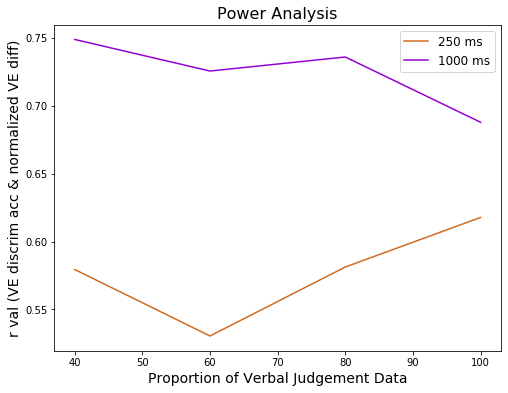

In [225]:
plt.figure(figsize=[8,6])

xaxis = [40, 60, 80, 100]
# correlation values for each duration 
y_250 = [r_250_40p[0], r_250_60p[0], r_250_80p[0], r_250_100p[0]]
y_1000 = [r_1000_40p[0], r_1000_60p[0], r_1000_80p[0], r_1000_100p[0]]

plt.plot(xaxis, y_250, label='250 ms', color='chocolate')
plt.plot(xaxis, y_1000, label='1000 ms', color='darkviolet')

plt.xlabel('Proportion of Verbal Judgement Data', fontsize=14)
plt.ylabel('r val (VE discrim acc & normalized VE diff)', fontsize=14)

plt.legend(fontsize=12)

plt.title('Power Analysis', fontsize=16)
plt.show();

In [226]:
r_250_40p, r_1000_40p, r_250_60p, r_1000_60p, r_250_80p, r_1000_80p, r_250_100p, r_1000_100p

((0.5793975774745596, 5.269013703746627e-07),
 (0.7487050130349713, 1.1335044876358635e-12),
 (0.530485340846975, 6.51988680007552e-06),
 (0.7254641940098753, 1.1970640012121359e-11),
 (0.5812330374803334, 4.755806329147974e-07),
 (0.7358017202254872, 4.325042803112811e-12),
 (0.6177114340931786, 5.405997090885988e-08),
 (0.6877811799813451, 3.422231405495296e-10))

#### Correlation between durations

In [227]:
dur_acc_corr_40p = stats.pearsonr(VE_accuracy_250_40p, VE_accuracy_1000_40p)
dur_acc_corr_60p = stats.pearsonr(VE_accuracy_250_60p, VE_accuracy_1000_60p)
dur_acc_corr_80p = stats.pearsonr(VE_accuracy_250_80p, VE_accuracy_1000_80p)
dur_acc_corr_100p = stats.pearsonr(VE_accuracy_250_100p, VE_accuracy_1000_100p)


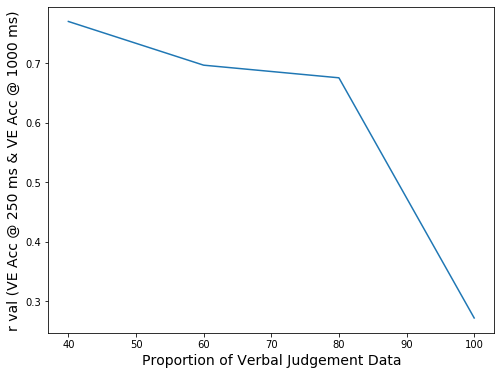

In [228]:
plt.figure(figsize=[8,6])

xaxis = [40, 60, 80, 100]
# correlation values for each duration 
y_dur_acc_corr = [dur_acc_corr_40p[0], dur_acc_corr_60p[0], dur_acc_corr_80p[0], dur_acc_corr_100p[0]]

plt.plot(xaxis, y_dur_acc_corr)

plt.xlabel('Proportion of Verbal Judgement Data', fontsize=14)
plt.ylabel('r val (VE Acc @ 250 ms & VE Acc @ 1000 ms)', fontsize=14)

plt.show();

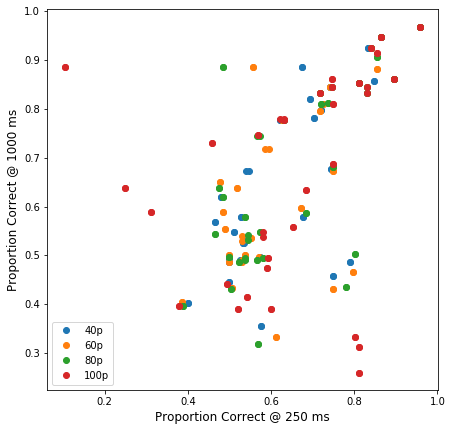

In [229]:
plt.figure(figsize=[7,7])
plt.xlabel('Proportion Correct @ 250 ms', fontsize=12)
plt.ylabel('Proportion Correct @ 1000 ms', fontsize=12)

plt.plot(VE_accuracy_250_40p,VE_accuracy_1000_40p, 'o', label='40p')
plt.plot(VE_accuracy_250_60p,VE_accuracy_1000_60p, 'o', label='60p')
plt.plot(VE_accuracy_250_80p,VE_accuracy_1000_80p, 'o', label='80p')
plt.plot(VE_accuracy_250_100p,VE_accuracy_1000_100p, 'o', label='100p')

plt.legend()

plt.show();